# Intro of Four Quadrant Method.

This approach is first suggested by Victor Lo in this [presentation](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). It suggested designing a model to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and responded. Basically received promotion and made a purchase.
CR: Control and Responded. Did not received promotion but made a purchase.
TN: Treatment and No Response. Received promotion but made no purchase.
CN: Control and No Response. Did not receive a promotion and made no purchase.

If an individual's TR probability is the highest among four groups, it is likely that we will benfit by sending the individual a promotion to induce him or her to make a purchase. In other words, if for an individual:

$$ max[P(TR), P(CR), P(TN), P(CN)] = P(TR)$$

we should send a promotion.

This model achieved an IRR of 1.56\% and NLR of - \\$0.30 on the validation set, and an IRR of 1.55\% and NLR of \\$5.90 on the test set. This model's performance among the validation and test set is relatively stable, but it certainly did not generate very favourable results. Still, It does seem to produce a small positive NLR on the test set.

Alternative models, feature generation, and upsampling techniques can be tried to improve the results.

In [2]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

## Import the Data

In [3]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

## Target Value

In [4]:
target = []
for index, row in train_data.iterrows():
    if (row['Promotion'] == "Yes") & (row['purchase'] == 1):
        # TR group
        target.append(0)
    elif (row['Promotion'] == "No") & (row['purchase'] == 1):
        # CR group
        target.append(1)
    elif (row['Promotion'] == "Yes") & (row['purchase'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,3
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,3
2,4,No,0,2,30.431659,0.133583,1,1,4,2,3
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,3
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,2


## Split

In [8]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

## Smote

In [11]:
Y_train.value_counts()

3    33444
2    33351
0      580
1      252
Name: target, dtype: int64

In [12]:
# up sample with SMOTE the largest value using SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

3    33444
2    33444
1    33444
0    33444
dtype: int64

## Training Classifier

In [50]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  early_stopping_rounds = 100,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

# eval set in XGBClassifier.

[0]	validation_0-mlogloss:1.33954	validation_1-mlogloss:1.35545
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.2983	validation_1-mlogloss:1.32799
[2]	validation_0-mlogloss:1.26209	validation_1-mlogloss:1.30371
[3]	validation_0-mlogloss:1.22944	validation_1-mlogloss:1.28116
[4]	validation_0-mlogloss:1.19955	validation_1-mlogloss:1.26115
[5]	validation_0-mlogloss:1.17269	validation_1-mlogloss:1.24233
[6]	validation_0-mlogloss:1.14754	validation_1-mlogloss:1.22489
[7]	validation_0-mlogloss:1.12463	validation_1-mlogloss:1.20859
[8]	validation_0-mlogloss:1.10321	validation_1-mlogloss:1.19388
[9]	validation_0-mlogloss:1.08088	validation_1-mlogloss:1.1792
[10]	validation_0-mlogloss:1.06147	validation_1-mlogloss:1.16579
[11]	validation_0-mlogloss:1.04484	validation_1-mlogloss:1.1538
[12]	validation_0-mlogloss:1.02803	validation_1-mlogloss:1.1426
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=100, gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

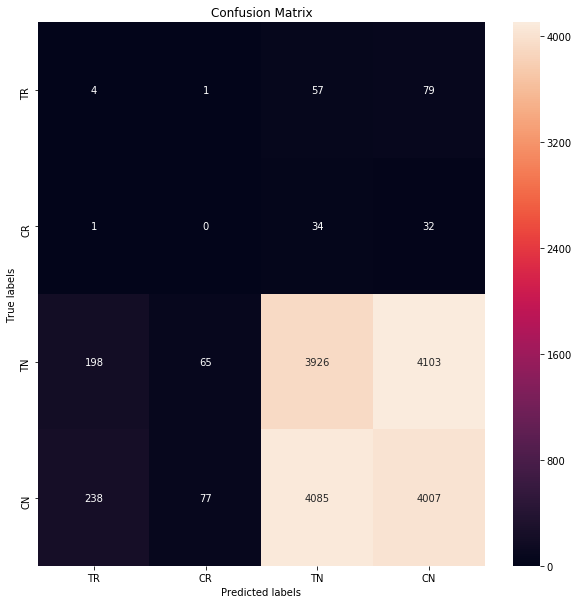

In [15]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [16]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [27]:
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print("Nice job!  See how well your strategy worked on our valid data below!")
    print()
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("We came up with a model with an irr of {} and an nir of {} on the test set.\n\n How did you do?".format(0.0188, 189.45))
    return irr, nir

In [29]:
df= valid[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

In [30]:
promotion_strategy(df)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [17]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0156.

Your nir with this strategy is -0.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01561787977960976, -0.29999999999999716)

In [39]:
promos= model.predict(df, ntree_limit=model.best_ntree_limit)

In [40]:
np.where(promos='Yes')

TypeError: where() takes no keyword arguments

In [43]:
valid.iloc[np.where(promos =='Yes')]

/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target


In [41]:
valid_data.iloc[np.where(promos == 'Yes')]    

NameError: name 'valid_data' is not defined

In [42]:
valid

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
6264,9346,Yes,0,3,18.012754,-1.511395,2,2,4,1,2
41822,62172,No,0,2,28.676557,-0.126150,2,3,3,2,3
8569,12768,No,0,0,28.817748,-1.511395,2,4,3,2,3
41228,61264,No,0,1,26.140783,-0.905350,2,1,4,2,3
24896,37024,Yes,0,1,32.346423,0.566472,1,2,3,1,2
45830,68194,Yes,0,1,29.904408,-0.039572,2,2,2,1,2
61302,91331,Yes,0,1,35.837661,1.172517,2,2,4,1,2
60120,89596,Yes,0,0,35.919967,-1.165083,2,3,1,2,2
75899,113261,No,0,0,34.634194,0.912784,2,3,4,2,3
67557,100722,No,0,1,36.568502,0.739628,1,3,1,1,3


In [22]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0155.

Your nir with this strategy is 5.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.015464544490973224, 5.900000000000006)

In [26]:
promotion_strategy(valid)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Promotion

In [24]:
valid.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
6264,9346,Yes,0,3,18.012754,-1.511395,2,2,4,1,2
41822,62172,No,0,2,28.676557,-0.126150,2,3,3,2,3
8569,12768,No,0,0,28.817748,-1.511395,2,4,3,2,3
41228,61264,No,0,1,26.140783,-0.905350,2,1,4,2,3
24896,37024,Yes,0,1,32.346423,0.566472,1,2,3,1,2
